This file is the main file where we define the problem data, initiate model and train the model

1. First we import all the relevant classes and libraries

In [46]:
import torch
import torch.nn as nn
from torch.autograd import grad
import math
import matplotlib.pyplot as plt
import numpy as np

Custom function needed to generate training and testing data

In [47]:
def generate_grid_1d(length, samples=20, initial_coordinate=0.0):
    """Generate an evenly space grid of a given length and a given number of samples."""

    # Generate the grid
    x = torch.linspace(initial_coordinate, initial_coordinate + length, samples, requires_grad=True)

    # Reshape on a column tensor and return
    return x.view(samples, 1)

2. Analytical 'u' is given

In [38]:
L = 1
x = generate_grid_1d(L, 20)
u_analytic = lambda x: torch.sin(2*math.pi*x)
u = u_analytic(x)
x_test = generate_grid_1d(L, 100)

Analytical inverse solution for validation

In [39]:
EA_analytic = lambda x: x**3 - x**2 + 1

3. Problem data are defined. Here the known data like boundary condition and loading conditions are defined

In [40]:
distLoad = lambda x: -2*(3*x**2 - 2*x)*math.pi*torch.cos(2*math.pi*x) + 4*(x**3 - x**2 + 1)*math.pi**2*torch.sin(2*math.pi*x)

## Main Function:

In [41]:
def InversePhysicsInformedBarModel(x, x_test,u, L, distLoad):
    

    class NeuralNetwork(nn.Module):
        def __init__(self):
            super(NeuralNetwork, self).__init__()
            self.hidden_layer = nn.Linear(2, 20)
            self.activation = nn.Tanh()
            self.output_layer = nn.Linear(20, 1)

        def forward(self, x1,u):
            x = torch.cat((x1, u), dim=1)
            x = self.hidden_layer(x)
            x = self.activation(x)
            x = self.output_layer(x)
            return x
    model = NeuralNetwork()
    EA = model.forward(x,u)
    def loss_(x,u):
        EA = model.forward(x,u)
        dudx = grad(u,x,torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        d2udx2 = grad(EA*dudx, x, torch.ones_like(EA*dudx), retain_graph = True,create_graph=True )[0]
        loss_fn = nn.MSELoss()
        r = d2udx2 + distLoad(x)
        loss = loss_fn(r, torch.zeros_like(r))
        return loss
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
    epochs = 1000
    l = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = loss_(x,u)
        l.append(loss.detach().numpy())
        loss.backward(retain_graph=True)
        optimizer.step()
        model.eval()
    
        if epoch%50==0:
            print(epoch,"Loss: " , loss.detach().numpy())
    
        
    u_test = u_analytic(x_test)   
    return model.forward(x_test,u_test),l
    

4. Next we generate the neural network model using the imported class InversePhysicsInformedBarModel

In [42]:
pinnModel,loss = InversePhysicsInformedBarModel(x,x_test, u, L, distLoad) # custom class defined in physicsinformed.py file

0 Loss:  661.79706
50 Loss:  5.6106453
100 Loss:  4.740133
150 Loss:  4.3447704
200 Loss:  4.003057
250 Loss:  3.7171006
300 Loss:  3.4771867
350 Loss:  3.2678123
400 Loss:  3.0707684
450 Loss:  2.8656113
500 Loss:  2.622804
550 Loss:  2.282866
600 Loss:  1.7459415
650 Loss:  1.0029348
700 Loss:  0.37300074
750 Loss:  0.122259356
800 Loss:  0.07146462
850 Loss:  0.059212644
900 Loss:  0.051989812
950 Loss:  0.046388783


6. We generate sample test data using utilities library and then predict the displacements at those test points


In [43]:
EA_Pred = pinnModel.detach().numpy()
EA_True = EA_analytic(x_test).detach().numpy()

7. We plot predicted coefficient (EA) at test points and also the training history

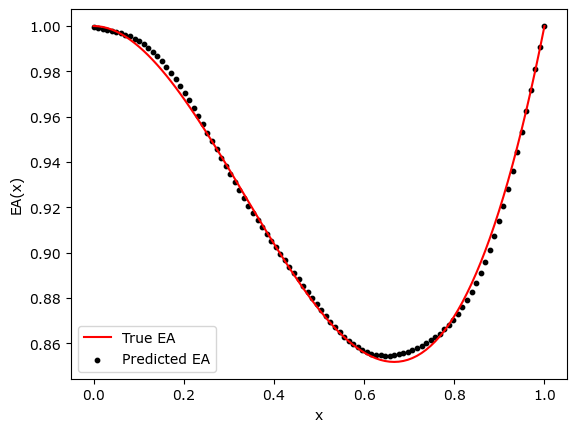

In [44]:
l = np.linspace(0,1,100)

plt.plot(l,EA_True, c='r', label = "True EA")
plt.scatter(l, EA_Pred, s=10, c='black', label = "Predicted EA")
plt.xlabel("x")
plt.ylabel("EA(x)")
plt.legend()

Text(0, 0.5, 'Loss')

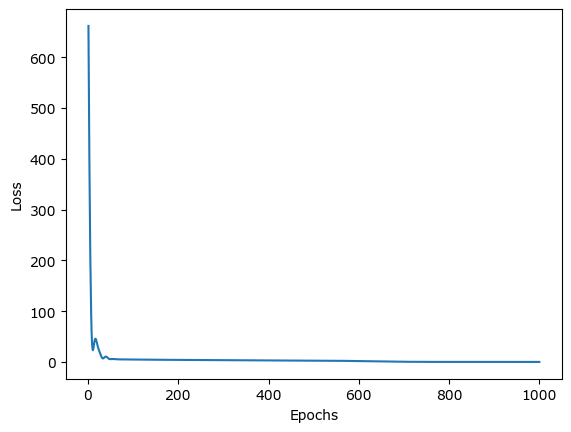

In [45]:
plt.plot(np.arange(1,len(loss)+1,1),loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")

I experimented with the optimizers and the hyperparameters associated with them and found this setting to work best for our problem